In [13]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('resumes_data.csv')
unique_labels = df['label'].unique()
print("Number of different labels:", len(unique_labels))

Number of different labels: 552


# Explore Data

In [10]:
all_labels = []
for labels in df['label'].dropna():
    all_labels.extend(labels.split(';'))

unique_job_labels = set(all_labels)
num_unique_jobs = len(unique_job_labels)

print(f"Total number of different occupations in the data: {num_unique_jobs}")
print("List of occupations:")
for job in sorted(unique_job_labels):
    print(job)

Total number of different occupations in the data: 10
List of occupations:
Database_Administrator
Front_End_Developer
Java_Developer
Network_Administrator
Project_manager
Python_Developer
Security_Analyst
Software_Developer
Systems_Administrator
Web_Developer


C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_10404\3504767306.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


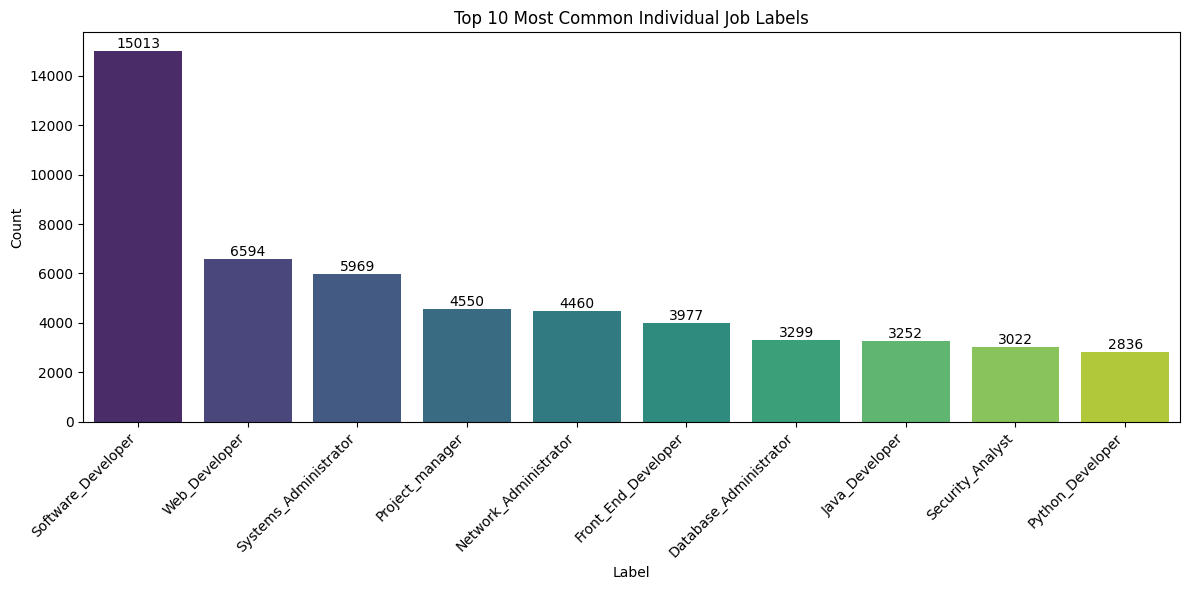


Exact counts:
Software_Developer: 15013
Web_Developer: 6594
Systems_Administrator: 5969
Project_manager: 4550
Network_Administrator: 4460
Front_End_Developer: 3977
Database_Administrator: 3299
Java_Developer: 3252
Security_Analyst: 3022
Python_Developer: 2836


In [11]:
# Extract individual labels from all combined labels
all_individual_labels = []
for labels in df['label'].dropna():
    all_individual_labels.extend(labels.split(';'))

individual_label_counts = pd.Series(all_individual_labels).value_counts()

top_10_individual = individual_label_counts.head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_10_individual.index,
    y=top_10_individual.values,
    palette='viridis'
)

for i, v in enumerate(top_10_individual.values):
    ax.text(
        i, v, str(int(v)),
        ha='center', va='bottom',
        fontsize=10
    )

plt.title('Top 10 Most Common Individual Job Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("\nExact counts:")
for label, count in top_10_individual.items():
    print(f"{label}: {int(count)}")

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_10404\3985967175.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


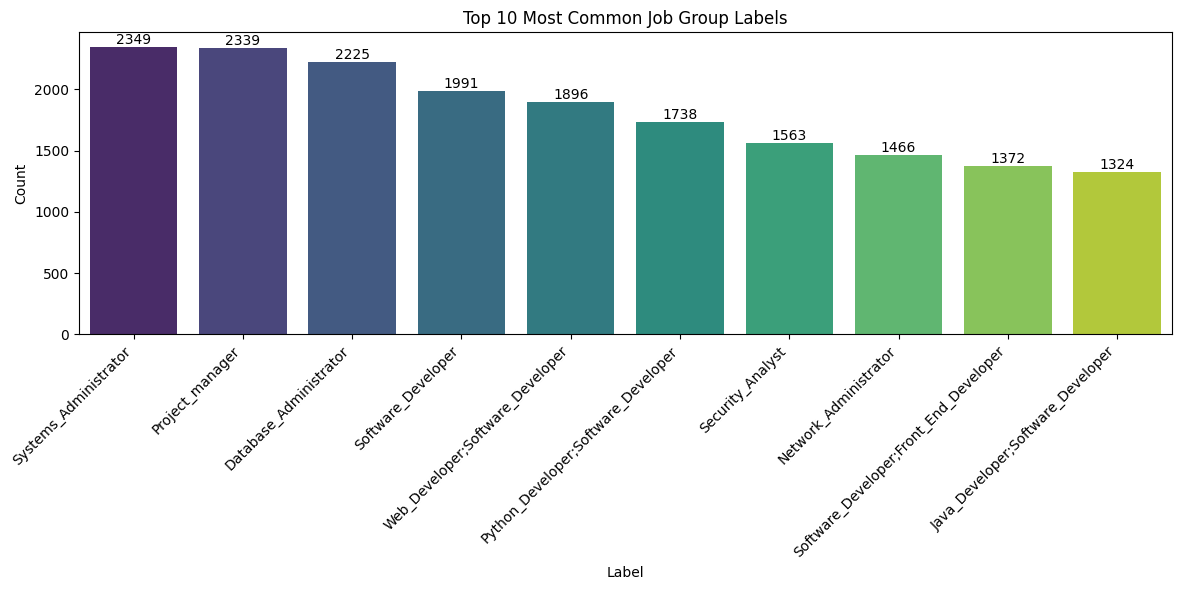

(552,
                                     label  count
 0                   Systems_Administrator   2349
 1                         Project_manager   2339
 2                  Database_Administrator   2225
 3                      Software_Developer   1991
 4        Web_Developer;Software_Developer   1896
 5     Python_Developer;Software_Developer   1738
 6                        Security_Analyst   1563
 7                   Network_Administrator   1466
 8  Software_Developer;Front_End_Developer   1372
 9       Java_Developer;Software_Developer   1324)

In [12]:
unique_labels = df['label'].unique()
num_unique_labels = len(unique_labels)

label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Get top 10 labels
top_10_labels = label_counts.head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='label',
    y='count',
    data=top_10_labels,
    palette='viridis'
)

for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f'{int(height)}',
        xy=(patch.get_x() + patch.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.title('Top 10 Most Common Job Group Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

num_unique_labels, top_10_labels

In [13]:
label_counts = df['label'].value_counts()

# Get maximum and minimum labels
max_label = label_counts.max()
min_label = label_counts.min()

# Calculate imbalance ratio
imbalance_ratio = max_label / min_label

print(f"Most common label: {label_counts.idxmax()}:{max_label} samples")
print(f"Least common label: {label_counts.idxmin()}:{min_label} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

Most common label: Systems_Administrator:2349 samples
Least common label: Project_manager;Database_Administrator;Software_Developer;Web_Developer;Network_Administrator:1 samples
Imbalance ratio: 2349.00x


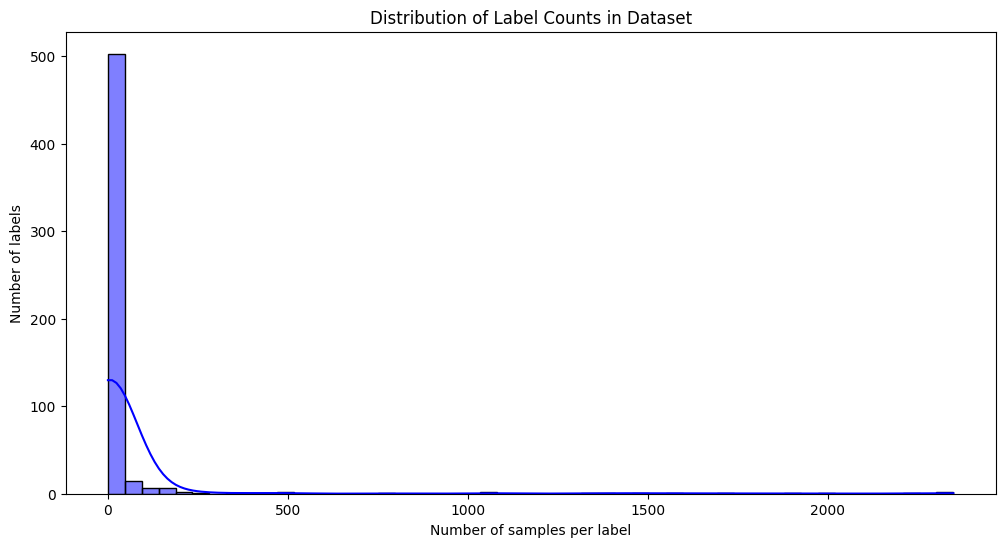

In [14]:
# Distribution plot of labels
plt.figure(figsize=(12, 6))
sns.histplot(label_counts, bins=50, kde=True, color="blue")

plt.title("Distribution of Label Counts in Dataset")
plt.xlabel("Number of samples per label")
plt.ylabel("Number of labels")
plt.show()

In [15]:
# Define job groups
job_groups = {
    "Database_Administrator": ["Database_Administrator"],
    "Front_End_Developer": ["Front_End_Developer"],
    "Java_Developer": ["Java_Developer"],
    "Network_Administrator": ["Network_Administrator"], 
    "Project_Manager": ["Project_manager"],
    "Python_Developer": ["Python_Developer"],
    "Security_Analyst": ["Security_Analyst"],
    "Software_Developer": ["Software_Developer"],
    "Systems_Administrator": ["Systems_Administrator"],
    "Web_Developer": ["Web_Developer"]
}

# Function to map labels to main groups
def map_to_group(label_list):
    for group, keywords in job_groups.items():
        for keyword in keywords:
            if keyword in label_list:
                return group
    return "Other" 

# Map all labels to groups
df['job_group'] = df['label'].apply(lambda x: map_to_group(x.split(';')) if pd.notna(x) else "Other")
group_counts = df['job_group'].value_counts()
print(group_counts)

job_group
Software_Developer        4607
Network_Administrator     4272
Front_End_Developer       3945
Project_Manager           3493
Database_Administrator    3299
Java_Developer            2871
Systems_Administrator     2349
Python_Developer          2260
Security_Analyst          1939
Other                      748
Name: count, dtype: int64


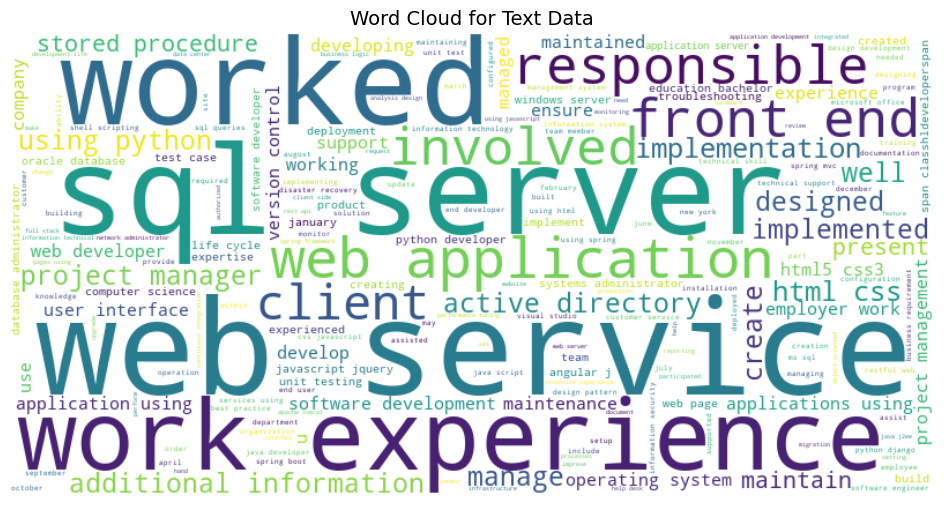

In [16]:
text_data = " ".join(df['text'].dropna())

# Preprocess text: remove special characters, convert to lowercase
text_data = re.sub(r'[^\w\s]', '', text_data.lower())

wordcloud = WordCloud(
    width=800, height=400, background_color="white",
    colormap="viridis", max_words=200
).generate(text_data)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Text Data", fontsize=14)
plt.show()


In [17]:
text_data = df['text'].dropna().tolist()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_features=50)  # Get top 20 important words

# Fit and transform text data
tfidf_matrix = vectorizer.fit_transform(text_data)

# Get the list of important words
important_words = vectorizer.get_feature_names_out()

print("📌 Top important words according to TF-IDF:")
print(important_words)

📌 Top important words according to TF-IDF:
['application' 'applications' 'based' 'business' 'created' 'css' 'data'
 'database' 'design' 'developed' 'developer' 'development' 'end'
 'environment' 'experience' 'html' 'implemented' 'information' 'java'
 'javascript' 'jquery' 'js' 'management' 'network' 'new' 'oracle'
 'project' 'python' 'security' 'server' 'service' 'services' 'skills'
 'software' 'span' 'spring' 'sql' 'support' 'systems' 'team' 'technical'
 'testing' 'used' 'user' 'using' 'web' 'windows' 'work' 'worked' 'years']


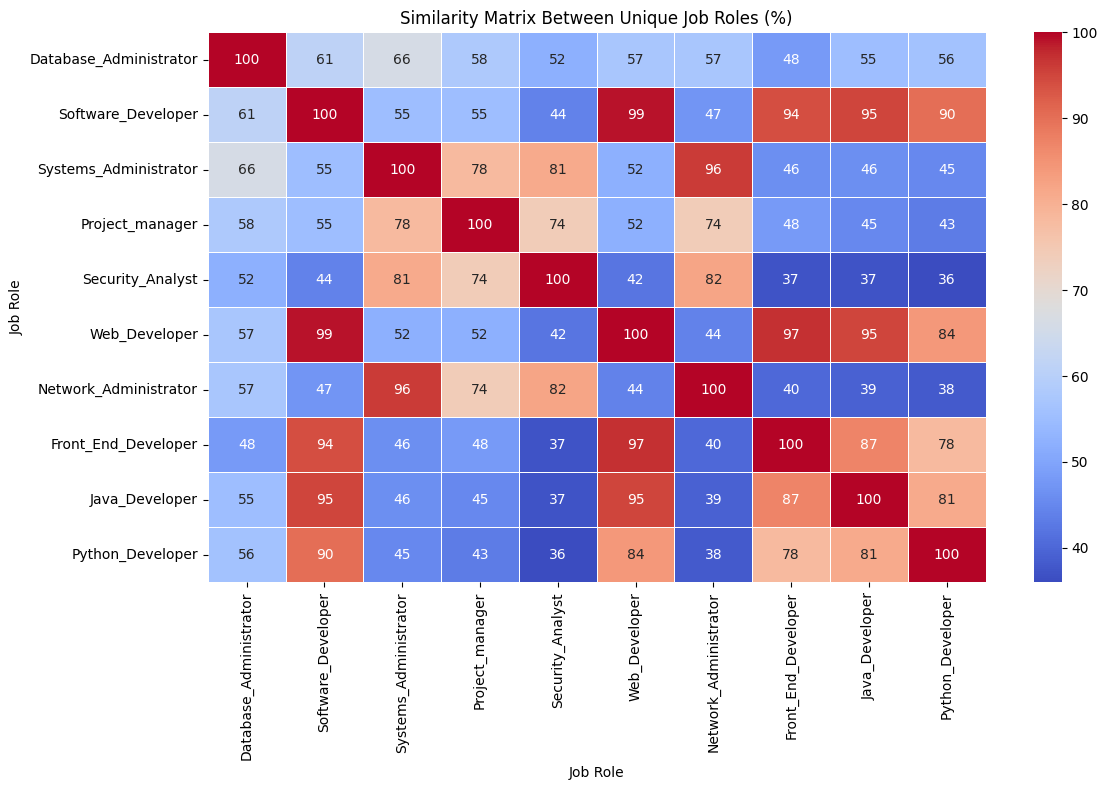

In [23]:

unique_jobs = [
    'Database_Administrator',
    'Front_End_Developer',
    'Java_Developer',
    'Network_Administrator', 
    'Project_manager',
    'Python_Developer',
    'Security_Analyst',
    'Software_Developer',
    'Systems_Administrator',
    'Web_Developer'
]

# Filter and aggregate text data for each unique job role
filtered_texts = []
filtered_labels = []

for label in df['label']:
    if pd.notna(label):  # Check for non-NaN values
        job_labels = label.split(';')
        if any(job in unique_jobs for job in job_labels):
            for job in job_labels:
                if job in unique_jobs and job not in filtered_labels:
                    filtered_labels.append(job)
                    # Aggregate all text data for this job role
                    mask = df['label'].apply(lambda x: job in str(x).split(';') if pd.notna(x) else False)
                    texts = ' '.join(df[mask]['text'])
                    filtered_texts.append(texts)

job_texts = pd.DataFrame({
    'label': filtered_labels,
    'text': filtered_texts
})

# Compute TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(job_texts['text'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

job_sim_matrix = pd.DataFrame(cosine_sim, 
                            index=job_texts['label'], 
                            columns=job_texts['label'])

job_sim_matrix_percentage = (job_sim_matrix * 100).round(0)

plt.figure(figsize=(12, 8))
sns.heatmap(job_sim_matrix_percentage, 
            cmap="coolwarm", 
            linewidths=0.5, 
            annot=True, 
            fmt='.0f')
plt.title("Similarity Matrix Between Unique Job Roles (%)")
plt.xlabel("Job Role")
plt.ylabel("Job Role")
plt.tight_layout()
plt.show()

### Check token with first 512 tokens, and after 512 tokens

In [20]:
def split_text(text, n=512):
    """Split text into two parts at the nth token."""
    tokens = str(text).split()
    part1 = " ".join(tokens[:n])
    part2 = " ".join(tokens[n:]) if len(tokens) > n else ""
    return part1, part2

# Split text data into two parts
df[['text_part1', 'text_part2']] = df['text'].apply(
    lambda x: pd.Series(split_text(x, 512))
)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

# Calculate TF-IDF for first part
X_part1 = vectorizer.fit_transform(df['text_part1'])
feature_names1 = vectorizer.get_feature_names_out()
tfidf_mean_part1 = X_part1.mean(axis=0).A1
top_part1_indices = tfidf_mean_part1.argsort()[::-1][:20]
top_terms_part1 = [(feature_names1[i], tfidf_mean_part1[i]) 
                   for i in top_part1_indices]

# Calculate TF-IDF for second part
X_part2 = vectorizer.fit_transform(df['text_part2'].fillna(""))
feature_names2 = vectorizer.get_feature_names_out()
tfidf_mean_part2 = X_part2.mean(axis=0).A1
top_part2_indices = tfidf_mean_part2.argsort()[::-1][:20]
top_terms_part2 = [(feature_names2[i], tfidf_mean_part2[i]) 
                   for i in top_part2_indices]

# Print results
print("\nTop 20 terms with highest average TF-IDF in first 512 tokens:")
for term, score in top_terms_part1:
    print(f"{term}: {score:.4f}")

print("\nTop 20 terms with highest average TF-IDF after 512 tokens:")
for term, score in top_terms_part2:
    print(f"{term}: {score:.4f}")


Top 20 terms with highest average TF-IDF in first 512 tokens:
web: 0.0464
using: 0.0463
developer: 0.0438
span: 0.0425
experience: 0.0382
security: 0.0367
network: 0.0355
python: 0.0344
data: 0.0341
project: 0.0337
software: 0.0329
systems: 0.0325
database: 0.0312
development: 0.0308
administrator: 0.0297
management: 0.0285
years: 0.0285
support: 0.0284
sql: 0.0274
server: 0.0269

Top 20 terms with highest average TF-IDF after 512 tokens:
using: 0.0511
years: 0.0366
data: 0.0357
web: 0.0351
sql: 0.0301
used: 0.0300
application: 0.0285
server: 0.0274
python: 0.0271
developed: 0.0267
database: 0.0262
management: 0.0251
project: 0.0235
javascript: 0.0231
development: 0.0223
security: 0.0220
java: 0.0207
network: 0.0196
services: 0.0194
spring: 0.0189


In [22]:
def get_first_n_tokens(text, n=512):
    tokens = str(text).split()
    return " ".join(tokens[:n])

df['text_512'] = df['text'].astype(str).apply(lambda t: get_first_n_tokens(t, n=512))

# Fixed list of target industries with consistent naming
target_labels = [
    'Database_Administrator', 'Front_End_Developer', 'Java_Developer',
    'Network_Administrator', 'Project_Manager', 'Python_Developer',
    'Security_Analyst', 'Software_Developer', 'Systems_Administrator',
    'Web_Developer'
]

# Split multi-labels into individual labels
df['label_list'] = df['label'].apply(lambda x: [i.strip() for i in str(x).split(';')])

# Create exploded dataframe for single-label analysis
df_exploded = df.explode('label_list')

def top_tfidf_terms_for_label(df_label, label_name):
    """Get top 20 TF-IDF terms for a specific label."""
    if len(df_label) < 2:  # Added minimum sample check
        print(f"\nNot enough samples for '{label_name}' to perform TF-IDF analysis.")
        return
        
    vectorizer_label = TfidfVectorizer(max_features=10000, stop_words='english')
    
    try:
        # Fit TF-IDF on subset data
        X_label_tfidf = vectorizer_label.fit_transform(df_label['text_512'])
        feature_names_label = vectorizer_label.get_feature_names_out()

        # Calculate mean TF-IDF scores
        tfidf_label_mean_scores = X_label_tfidf.mean(axis=0).A1

        # Get top 20 terms with highest mean TF-IDF
        top_indices = tfidf_label_mean_scores.argsort()[::-1][:20]
        top_terms = [(feature_names_label[i], tfidf_label_mean_scores[i]) 
                    for i in top_indices]

        # Print results
        print(f"\nTop 20 terms with highest mean TF-IDF for '{label_name}':")
        for term, score in top_terms:
            print(f"{term}: {score:.4f}")
            
    except Exception as e:
        print(f"\nError analyzing '{label_name}': {str(e)}")

# Analyze each label
for label in target_labels:
    df_label_subset = df_exploded[df_exploded['label_list'] == label]

    if df_label_subset.empty:
        print(f"\nNo data found for '{label}'.")
        continue

    if len(df_label_subset) < 5:
        print(f"\n'{label}' has only {len(df_label_subset)} samples, "
              "may not be enough for analysis.")
    
    top_tfidf_terms_for_label(df_label_subset, label)



Top 20 terms with highest mean TF-IDF for 'Database_Administrator':
database: 0.1107
oracle: 0.0766
sql: 0.0751
data: 0.0587
server: 0.0547
administrator: 0.0447
span: 0.0424
databases: 0.0419
using: 0.0404
experience: 0.0348
performance: 0.0310
support: 0.0292
management: 0.0286
security: 0.0260
tuning: 0.0256
development: 0.0251
years: 0.0249
recovery: 0.0246
systems: 0.0244
production: 0.0243

Top 20 terms with highest mean TF-IDF for 'Front_End_Developer':
web: 0.0785
using: 0.0719
developer: 0.0667
end: 0.0618
experience: 0.0577
span: 0.0560
js: 0.0494
development: 0.0421
javascript: 0.0415
design: 0.0410
ui: 0.0387
years: 0.0385
css: 0.0375
angular: 0.0368
applications: 0.0334
application: 0.0322
like: 0.0321
jquery: 0.0309
react: 0.0287
class: 0.0286

Top 20 terms with highest mean TF-IDF for 'Java_Developer':
using: 0.1052
experience: 0.1038
java: 0.0851
spring: 0.0743
web: 0.0713
like: 0.0592
developer: 0.0565
development: 0.0541
application: 0.0462
applications: 0.0448
span:

# Check Data Errors

### Lost data

In [24]:
# Check missing values in each column
missing_values = df.isnull().sum()

# Calculate percentage of missing values
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_info['Status'] = missing_info['Percentage'].apply(
    lambda x: 'High' if x > 10 
    else ('Medium' if x > 5 
    else 'Low' if x > 0 
    else 'None'))

print("Missing Values Analysis:")
print("------------------------")
print(missing_info)

Missing Values Analysis:
------------------------
            Missing Values  Percentage Status
file_id                  0      0.0000   None
text                     0      0.0000   None
label                  748      2.5115    Low
job_group                0      0.0000   None
text_part1               0      0.0000   None
text_part2               0      0.0000   None
text_512                 0      0.0000   None
label_list               0      0.0000   None


In [25]:
# Display rows with missing values in the 'label' column
missing_rows = df[df['label'].isnull()]

print("Analysis of Missing Labels:")
print("------------------------------")
print(f"otal number of rows: {len(df)}")
print(f"Number of rows with missing labels: {len(missing_rows)}")
print(f"Percentage of missing labels: {(len(missing_rows)/len(df)*100):.2f}%")

if len(missing_rows) > 0:
    print("\n Sample of rows with missing labels:")
    display_cols = ['file_id', 'text', 'label']
    print(missing_rows[display_cols].head().to_string())
else:
    print("\n No missing labels found in the dataset.")

Analysis of Missing Labels:
------------------------------
otal number of rows: 29783
Number of rows with missing labels: 748
Percentage of missing labels: 2.51%

 Sample of rows with missing labels:
     file_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

### Duplicate data

In [ ]:
# Check for duplicate data (duplicate both text and label)
duplicated_indices = df[df.duplicated(subset=['text', 'label'], keep=False)].index

duplicates = []
checked = set()
for i in duplicated_indices:
    if i in checked:
        continue
    duplicate_group = df[(df['text'] == df.loc[i, 'text']) & (df['label'] == df.loc[i, 'label'])].index.tolist()
    if len(duplicate_group) > 1:
        for j in duplicate_group[1:]:
            duplicates.append((i, j, df.loc[i, 'text'], df.loc[j, 'text'], df.loc[i, 'label'], df.loc[j, 'label']))
        checked.update(duplicate_group)

# Count total number of duplicate pairs
total_duplicates = len(duplicates)
print(f"Total number of duplicate pairs in data (both text and label): {total_duplicates}")

print("\nList of 10 duplicate pairs:")
for idx, (i, j, text_i, text_j, label_i, label_j) in enumerate(duplicates[:10]):
    print(f"Pair {idx + 1}: Row {i} duplicates with row {j}")
    print(f"Row {i}: {text_i} | Label: {label_i}")
    print(f"Row {j}: {text_j} | Label: {label_j}")
    print("-" * 50)

### Tokenization

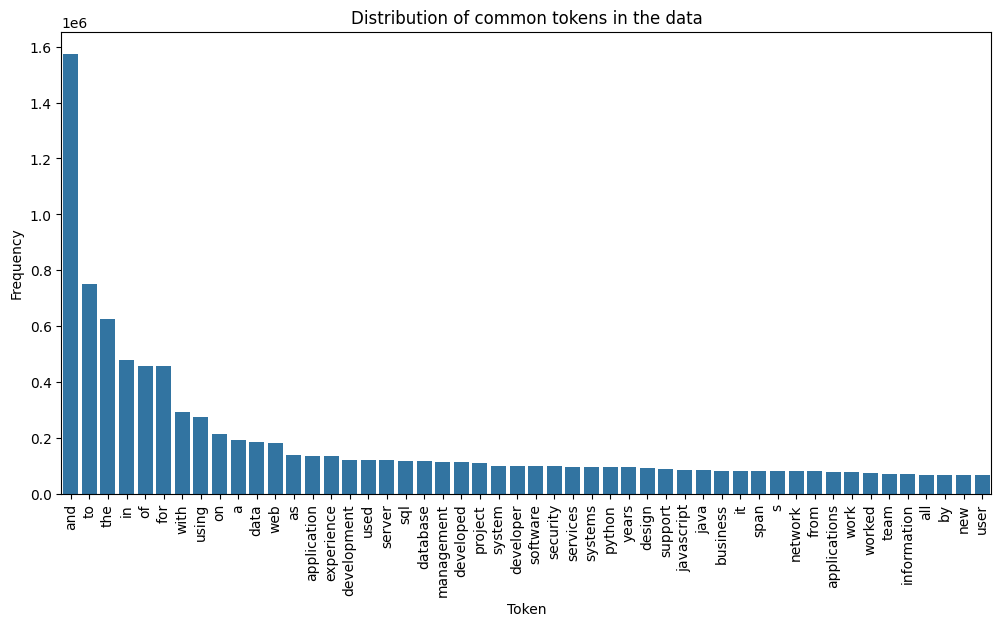

In [34]:
# Tokenization using regex
all_tokens = re.findall(r'\b\w+\b', " ".join(df['text']).lower())
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common(50)

tokens, counts = zip(*most_common_tokens)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(tokens), y=list(counts))
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title("Distribution of common tokens in the data")
plt.show()

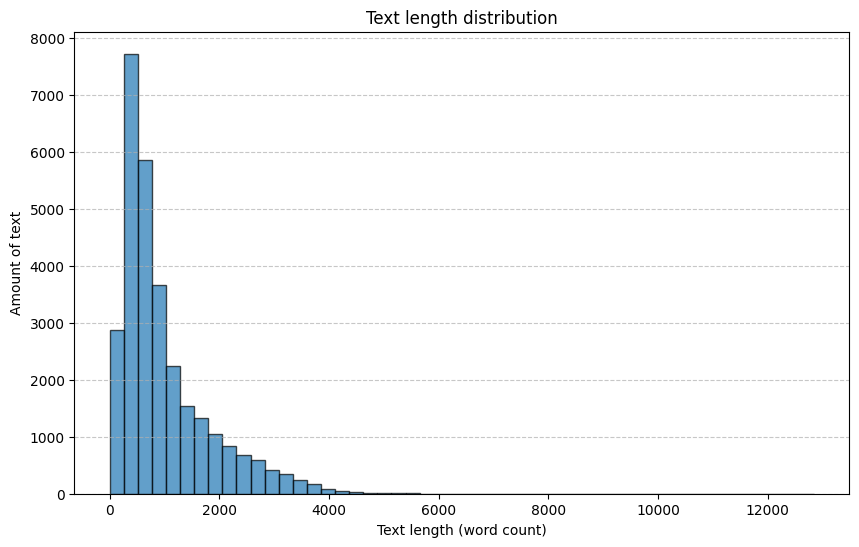

In [35]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Text length (word count)')
plt.ylabel('Amount of text')
plt.title('Text length distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

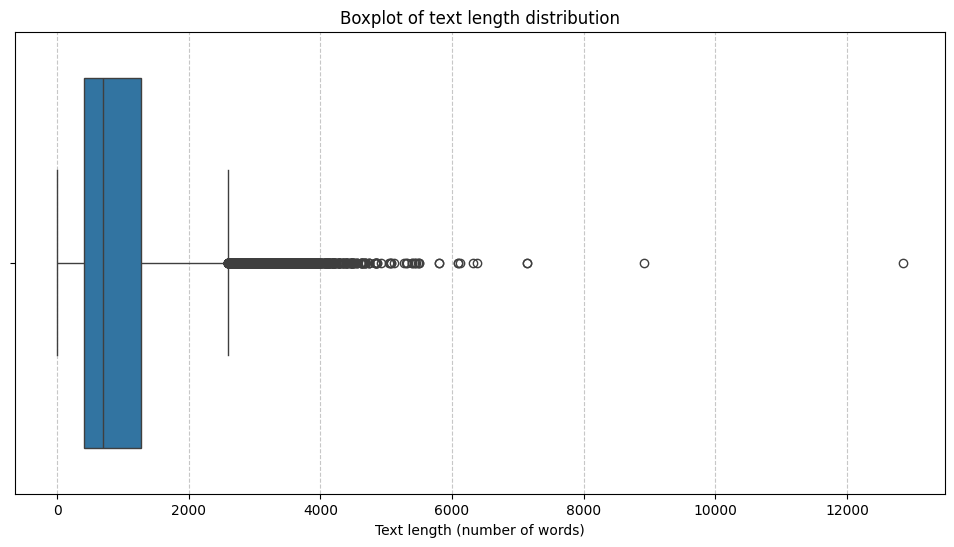

Total number of outlier texts: 1930

List of first 10 outlier texts:
                                                  text  text_length
42   SQL Server DBA SQL Server DBA SQL Server DBA -...         3860
71   Oracle Database Administrator Oracle <span cla...         2813
87   Senior Oracle Database Administrator Senior Or...         3565
204  Sr. Oracle DBA Sr. Oracle DBA Sr. Oracle DBA -...         4211
205  Sr. Oracle Database Administrator Sr. Oracle <...         3242
225  Oracle Database Administrator/Applications DBA...         3432
309  DevOps Cloud Architect DevOps Cloud Architect ...         2730
350  Database Administrator and Developer <span cla...         2802
382  Sr. Oracle Database Administrator Sr. Oracle <...         3306
408  Sr. Oracle Database Administrator Sr. Oracle <...         3598


In [36]:
# Calculate text length for each document
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['text_length'])
plt.xlabel('Text length (number of words)')
plt.title('Boxplot of text length distribution')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"Total number of outlier texts: {len(outliers)}")
print("\nList of first 10 outlier texts:")
print(outliers[['text', 'text_length']].head(10))

In [37]:
def analyze_text_percentages(df, threshold=2750):
    """
    Analyzes the percentage of words before and after the threshold for each text.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with 'text' column
        threshold (int): Word count threshold (default: 2750)
    
    Returns:
        dict: Dictionary containing statistics about text distribution
    """
    # Calculate word counts for each text
    word_counts = df['text'].apply(lambda x: len(str(x).split()))
    
    # Calculate statistics
    total_texts = len(df)
    texts_above_threshold = sum(word_counts > threshold)
    texts_below_threshold = sum(word_counts <= threshold)
    
    # Calculate percentages for texts above threshold
    percentages = []
    for text in df[word_counts > threshold]['text']:
        words = text.split()
        total_words = len(words)
        words_before = len(words[:threshold])
        
        percentage_before = (words_before / total_words) * 100
        percentage_after = 100 - percentage_before
        percentages.append((percentage_before, percentage_after))
    
    # Calculate average percentages
    avg_before = np.mean([p[0] for p in percentages]) if percentages else 0
    avg_after = np.mean([p[1] for p in percentages]) if percentages else 0
    
    # Prepare results
    stats = {
        'total_texts': total_texts,
        'texts_below_threshold': texts_below_threshold,
        'texts_above_threshold': texts_above_threshold,
        'percent_below_threshold': (texts_below_threshold / total_texts) * 100,
        'percent_above_threshold': (texts_above_threshold / total_texts) * 100,
        'avg_percent_before_threshold': avg_before,
        'avg_percent_after_threshold': avg_after
    }
    
    print(f"Total number of texts: {stats['total_texts']}")
    print(f"Texts below {threshold} words: {stats['texts_below_threshold']} ({stats['percent_below_threshold']:.2f}%)")
    print(f"Texts above {threshold} words: {stats['texts_above_threshold']} ({stats['percent_above_threshold']:.2f}%)")
    if percentages:
        print(f"\nFor texts above {threshold} words:")
        print(f"Average percentage before {threshold} words: {stats['avg_percent_before_threshold']:.2f}%")
        print(f"Average percentage after {threshold} words: {stats['avg_percent_after_threshold']:.2f}%")
    
    return stats

In [38]:
text_stats = analyze_text_percentages(df)

Total number of texts: 29783
Texts below 2750 words: 28216 (94.74%)
Texts above 2750 words: 1567 (5.26%)

For texts above 2750 words:
Average percentage before 2750 words: 83.86%
Average percentage after 2750 words: 16.14%


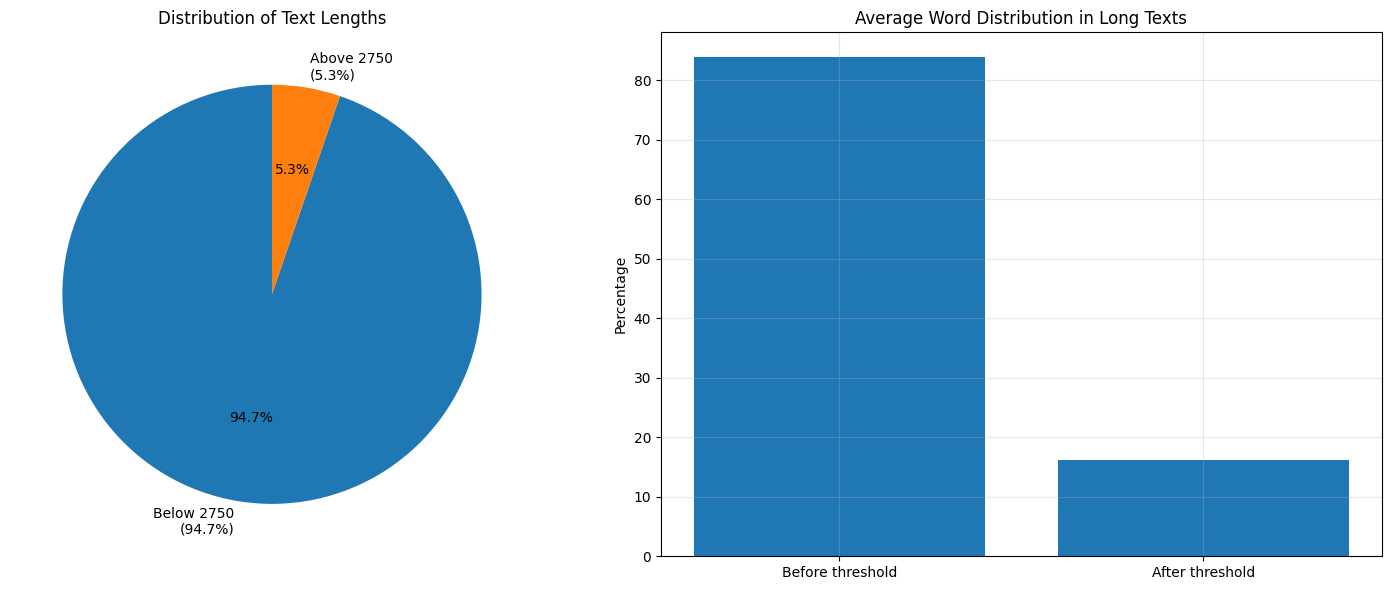

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

threshold = 2750  # Define the threshold value for word count
# Pie chart showing distribution of texts above/below threshold
pie_data = [
    text_stats['texts_below_threshold'],
    text_stats['texts_above_threshold']
]
pie_labels = [f'Below {threshold}\n({text_stats["percent_below_threshold"]:.1f}%)', 
              f'Above {threshold}\n({text_stats["percent_above_threshold"]:.1f}%)']
ax1.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of Text Lengths')

# Bar chart showing average word percentages for long texts
if text_stats['texts_above_threshold'] > 0:
    percentages = [
        text_stats['avg_percent_before_threshold'],
        text_stats['avg_percent_after_threshold']
    ]
    ax2.bar(['Before threshold', 'After threshold'], percentages)
    ax2.set_title('Average Word Distribution in Long Texts')
    ax2.set_ylabel('Percentage')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Abbreviations

In [40]:
abbreviation_pattern = r"\b[A-Z]{2,5}\b"

# Store list of abbreviations and their positions 
abbreviations = defaultdict(list)

for index, text in df['text'].items():
    found = re.findall(abbreviation_pattern, text)
    if found:
        abbreviations[index] = found

print(f"Total number of rows containing abbreviations: {len(abbreviations)}")
for i, (idx, abbrs) in enumerate(abbreviations.items()):
    print(f"Row {idx}: {', '.join(set(abbrs))}")
    if i >= 9:  # Only show first 10 rows
        break

Total number of rows containing abbreviations: 29768
Row 0: DBA, SSIS, MS, CDP, LLC, SOX, CPU, SSRS, OLTP, ETL, DB, GA, SQL
Row 1: SQL, DB, XP, TX, GU
Row 2: RMAN, NETCA, DBA, DBCA, AWR, ASM, ASH, CPU, ADDM, GUI, DB, US, PSU, JNTU, HTML, LINUX, SQL
Row 3: QUITO, PHP, MSP, RDS, CUBA, DBMS, AWS, IL, CEIGE, FL, US, ETL, NET, LA, SQL
Row 4: IMP, UX, EM, TOAD, RAC, OEM, RHEL, EXP, HP, VIP, ASM, CPU, RTA, PSU, CSM, SQL, RMAN, NON, RDBMS, VA, DC
Row 5: IMP, DEV, ETA, PL, ASH, DBMS, UX, OF, SCAN, BANK, PLAN, SRDF, OS, BAKER, AK, DBUA, RAC, RHEL, HP, OEM, DBA, EXP, MAC, STATS, ROCHE, TTS, GIS, PROD, US, OASIS, PC, IMPDP, JAR, LINUX, PDB, AIX, IT, RAW, MD, RAID, DBCA, AWR, IBM, ASM, UAT, FRA, CPU, UNIX, ADDM, FL, EXPDP, PSU, FOR, KS, FLASH, SQL, RMAN, SPM, APPS, CDB, EMC, TDE, AREA, BMC, VA, RUP, OLTP, TEST, SGA, DB, ESTES
Row 6: SDLC, IMP, DDL, MS, DBMS, ASH, PL, UX, EDW, SCI, PLAN, OS, TRACE, TAR, RAC, OEM, HP, EXP, DBA, DML, DISK, RDS, STATS, OH, TTS, CRON, PROD, IMPDP, LINUX, PDB, FTP, AIX, 

In [41]:
abbreviation_pattern = r"\b[A-Z]{2,5}\b"

# Store all found abbreviations in a set to remove duplicates
unique_abbreviations = set()

for text in df['text']:
    if isinstance(text, str):  # Check if text is a string
        found = re.findall(abbreviation_pattern, text)
        unique_abbreviations.update(found)

abbr_df = pd.DataFrame(sorted(unique_abbreviations), columns=['Abbreviation'])

print(f"Total number of unique abbreviations: {len(unique_abbreviations)}")
print(abbr_df)

Total number of unique abbreviations: 23412
      Abbreviation
0               AA
1              AAA
2             AAAA
3             AAAE
4             AAAI
...            ...
23407         ZXTM
23408         ZYME
23409         ZYTO
23410        ZYXEL
23411           ZZ

[23412 rows x 1 columns]


### Check Stopword

In [ ]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words("english"))

removed_stopwords = set()

# Iterate through each row in 'text' column
for text in df['text']:
    tokens = str(text).split()
    for token in tokens:
        token_lower = token.lower()
        if token_lower in STOP_WORDS:
            removed_stopwords.add(token_lower)

print("Removed stopwords (unique):")
print(sorted(removed_stopwords))